# Power outage analysis
**Name(s)**: Jiaying Chen, Minh Hoang

**Website Link**: (your website link)


**Note**: Run this command to install wordcloud:
`!pip install wordcloud`

In [21]:
!pip install wordcloud

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from wordcloud import WordCloud


import plotly.express as px
import plotly.graph_objects as go

#newly added
from scipy.stats import permutation_test #easy permutation testing
from itertools import combinations
from pandas.api.types import is_numeric_dtype
#model business
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression

pd.options.plotting.backend = 'plotly'

# from dsc80_utils import * # Feel free to uncomment and use this.

# Step 1: Introduction

### Loading data

In [2]:
# Drop first 5 rows of metadata
raw = pd.read_csv('outage.csv', header=None).iloc[5:]

# Extract and clean column names from the first actual row (index 5 in the original file)
cols = raw.iloc[0, 1:].tolist()
# Drop the first column (contains "variables") and the header row itself
raw = raw.iloc[1:, 1:].copy()

# Assign cleaned column names
raw.columns = cols

# Reset index so we are working with the correct row numbers.
raw.reset_index(drop=True, inplace=True)

# Finally, drop variable column 
raw = raw.iloc[1:, :]
raw.head(2)

,OBS,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START.DATE,...,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND
1,1,2011,7,Minnesota,MN,MRO,East North Central,-0.3,normal,"Friday, July 1, 2011",...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5926658691451,8.40733413085488,5.47874298334407
2,2,2014,5,Minnesota,MN,MRO,East North Central,-0.1,normal,"Sunday, May 11, 2014",...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5926658691451,8.40733413085488,5.47874298334407


### Renaming columns

In [3]:
new_cols = [
    'obs', 'year', 'month', 'state', 'postal_code', 'nerc_region',
    'climate_region', 'anomaly_level', 'climate_cat',
    'start_date', 'start_time', 'restore_date',
    'restore_time', 'cause_cat', 'cause_detail',
    'hurricane_names', 'duration', 'demand_loss_mw',
    'customers_affected', 'res_price', 'com_price', 'ind_price',
    'total_price', 'res_sales', 'com_sales', 'ind_sales', 'total_sales',
    'res_pct', 'com_pct', 'ind_pct', 'res_customers',
    'com_customers', 'ind_customers', 'total_customers', 'res_cust_pct',
    'com_cust_pct', 'ind_cust_pct', 'pc_realgsp_state', 'pc_realgsp_usa',
    'pc_realgsp_rel', 'pc_realgsp_change', 'util_realgsp', 'total_realgsp',
    'util_contri', 'pi_util_of_usa', 'population', 'pop_pct_urban',
    'pop_pct_uc', 'popden_urban', 'popden_uc', 'popden_rural',
    'area_pct_urban', 'area_pct_uc', 'pct_land', 'pct_water_tot',
    'pct_water_inland'
]

raw.columns = new_cols
raw.head(2)


,obs,year,month,state,postal_code,nerc_region,climate_region,anomaly_level,climate_cat,start_date,...,pop_pct_urban,pop_pct_uc,popden_urban,popden_uc,popden_rural,area_pct_urban,area_pct_uc,pct_land,pct_water_tot,pct_water_inland
1,1,2011,7,Minnesota,MN,MRO,East North Central,-0.3,normal,"Friday, July 1, 2011",...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5926658691451,8.40733413085488,5.47874298334407
2,2,2014,5,Minnesota,MN,MRO,East North Central,-0.1,normal,"Sunday, May 11, 2014",...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5926658691451,8.40733413085488,5.47874298334407


In [4]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1534 entries, 1 to 1534
Data columns (total 56 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   obs                 1534 non-null   object
 1   year                1534 non-null   object
 2   month               1525 non-null   object
 3   state               1534 non-null   object
 4   postal_code         1534 non-null   object
 5   nerc_region         1534 non-null   object
 6   climate_region      1528 non-null   object
 7   anomaly_level       1525 non-null   object
 8   climate_cat         1525 non-null   object
 9   start_date          1525 non-null   object
 10  start_time          1525 non-null   object
 11  restore_date        1476 non-null   object
 12  restore_time        1476 non-null   object
 13  cause_cat           1534 non-null   object
 14  cause_detail        1063 non-null   object
 15  hurricane_names     72 non-null     object
 16  duration            1476

## Introduction and Question Identification
(⚠️ means still need more data, ✅ means workable with existing data )

**Currently, we are considering three problem statement to explore:**

1. ⚠️ Assessment of Infrastructure Resilience (Based on whether or not `cause_detail` has enough information.)
Analyze how different regions' infrastructure characteristics (e.g., overhead vs. underground lines, maintenance investments) correlate with outage frequency and duration. This can inform infrastructure improvement strategies.
2. ✅ Temporal Trends and Climate Change Correlation (doable with existing data, but kinda boring) 
Examine how the frequency and causes of outages have evolved over time and assess potential correlations with climate change indicators. This can provide insights into how changing climate patterns impact power reliability.
3. ⚠️ Policy and Emergency Response Evaluation (We don’t have explicit timestamps or markers indicating policy changes or emergency response dates.)
Evaluate the effectiveness of policies and emergency responses by analyzing outage data before and after the implementation of specific measures. This can guide future policy development and emergency planning.

**Ideas that are just "ok":**

⭕️ 1. Predictive Modeling of Outage Risks <u> ***(but it’s kinda boring, i bet people have done it already; not creative)*** </u>

Utilize machine learning techniques to predict the likelihood of major power outages based on factors such as weather patterns, infrastructure characteristics, and economic indicators. This can aid in proactive maintenance and resource allocation.

⭕️ 2. Socioeconomic Impact Analysis <u> ***(has been done numerous times already !!!!!!! Check out examples, two of them already exist. I know you like it, Im sry!)*** </u>

Investigate the relationship between socioeconomic factors (e.g., income levels, urbanization) and the frequency or duration of power outages. This can highlight areas where outages disproportionately affect vulnerable populations.



### Exploring idea 1
Check out whether `cause_detail` gives us any good information about the infrustructure. 

In [5]:
raw['cause_detail'].unique()

array([nan, 'vandalism', 'heavy wind', 'thunderstorm', 'winter storm',
       'tornadoes', 'sabotage', 'hailstorm', 'uncontrolled loss',
       'winter', 'wind storm', 'computer hardware', 'public appeal',
       'storm', ' Coal', ' Natural Gas', 'hurricanes', 'wind/rain',
       'snow/ice storm', 'snow/ice ', 'transmission interruption',
       'flooding', 'transformer outage', 'generator trip',
       'relaying malfunction', 'transmission trip', 'lightning',
       'switching', 'shed load', 'line fault', 'breaker trip', 'wildfire',
       ' Hydro', 'majorsystem interruption', 'voltage reduction',
       'transmission', 'Coal', 'substation', 'heatwave',
       'distribution interruption', 'wind', 'suspicious activity',
       'feeder shutdown', '100 MW loadshed', 'plant trip', 'fog', 'Hydro',
       'earthquake', 'HVSubstation interruption', 'cables', 'Petroleum',
       'thunderstorm; islanding', 'failure'], dtype=object)

- `cause_detail` does contain some infrastructure-related failure types, like:
**transformer outage, generator trip, relaying malfunction, breaker trip, line fault, substation, transmission interruption, distribution interruption, cables, HVSubstation interruption, plant trip**, etc.
- They will allow us to indirectly infer infrastructure issues, but there are no explicit infrastructure metadata: We don’t have direct info on overhead vs underground lines, age of equipment, maintenance budgets, or investments.

- External datasets to consider: 
    - **(I FW THIS ONE HEAVY) [EIA Reports on Utility Investments](https://www.eia.gov/todayinenergy/detail.php?id=48136)** 
        - Provides financial and operational data related to maintenance and upgrades.
        - Can help explain or correlate investment levels with outage frequency/duration.
        - Good source for explaining patterns seen in outage data.
    - [Mapping the Depths: Underground Power Distribution (arXiv study, paper only)](https://arxiv.org/abs/2402.06668)
        - Unique dataset that quantifies underground vs overhead lines by utility.
        - Can provide a strong predictor variable about infrastructure type (underground = more resilient).

### Exploring EIA reports on utility investment 
-> <u> **[Annual Electric Power Industry Report, Form EIA-861 detailed data files](https://www.eia.gov/electricity/data/eia861/)**</u> <br>
-> <u> **[A Guide to EIA Electric Power Data](https://www.eia.gov/electricity/data/guide/pdf/guide.pdf)** page 9/18  </u> 
> **Retail Sales by Electric Utilities and Power Marketers (Form EIA-861, Annual Electric Power Industry Report)**
>
> Data Collected by Form EIA-861  
> The Form EIA-861, Annual Electric Power Industry Report collects annual data from a census of all utilities that sell electricity to end-use customers in the 50 states, the District of Columbia, Puerto Rico, American Samoa, the American Virgin Islands, Guam, and the Northern Mariana Islands. These surveys collect information on sales to ultimate customers by utilities and power marketers, energy efficiency programs, distributed generating capacity, and related data elements.  
>
> The data collected include several items:  
> - **Service territory by state and county**  
> - **Sales revenue to ultimate customers**  
> - **Revenue and customer count**  
> - **Source and disposition of electricity**  
> - **Advanced metering**  
> - **Demand response and energy efficiency programs**  
> - **Dynamic pricing**  
> - **Capacity and other information related to net metering**  
> - **Non-net metered distributed generating units**  
> - **Distribution system characteristics and reliability**


Out of the above, the good columns to look for are ` Distribution System Characteristics and Reliability`, ` Service Territory by State and County`, `Advanced Metering Infrastructure (AMI)`, `Revenue and Customer Count by Utility` 
-  `Distribution System Characteristics and Reliability`: Directly speaks to infrastructure resilience. 
-  `Service Territory by State and County`: Needed for merging 
- `Advanced Metering Infrastructure (AMI)`: AMI often correlates with modernization efforts and may reflect better outage response times. Can assess: Compare outage duration/frequency in regions with vs. without AMI.
- `Demand Response and Energy Efficiency Programs`: May suggest proactive infrastructure investment or mitigation strategies. Can assess: "Do regions with stronger demand response programs show fewer or shorter outages?"
- `Revenue and Customer Count by Utility`: Can assess possible correlations between revenue and investment in resilience.

### Setback and change of problem statement
However, later on into the project, we realized there are no good data sources for tracking state investment to power utilities. The form EIA 861 provides data that are already innate to the given outage dataframe.   
But we still want to focus on interesting supply side data, since demand-side data in the given dataframe has likely already been exploited and explored by many. Thus, we shifted our focus onto the operation and generation of electrical power supply instead of investment.  
We inspected **[other forms provided by EIA](https://www.eia.gov/electricity/data/state/)**, and two of we found interesting are the [EIA-860 Annual Electric Generator Report](https://www.eia.gov/electricity/data/eia860/), and the [EIA-923 Power Plant Operations Report](https://www.eia.gov/electricity/data/eia923/). At last, we came up with our final problem statement as below:




# How Electric Generation Infrastructure and Fuel Diversity Influence Grid Resilience Across U.S. States

Motivation:
While customer demand, pricing, and regional weather events are commonly studied in power outage analysis, much less attention is paid to how the supply-side characteristics of a state's power grid—including generation capacity, fuel mix, and generator diversity—contribute to its resilience. A robust grid isn't just about weather-proofing—it may also reflect investments in flexible infrastructure, diversified energy sources, and state-level energy planning.

Project Objective:
We investigate the relationship between generation capacity, fuel source diversity, and actual electricity generation (via EIA-860 and EIA-923) with outage frequency, duration, and impact (via DOE outage data).
We aim to answer:

Do states with more diverse energy portfolios experience fewer or shorter outages?

Does a higher capacity-to-population ratio correlate with better grid performance?

Are certain fuel sources (e.g., natural gas, renewables) associated with better resilience during high-demand or extreme weather years?



# Step 2: Data Cleaning and Exploratory Data Analysis

In [6]:
raw.head(2)

,obs,year,month,state,postal_code,nerc_region,climate_region,anomaly_level,climate_cat,start_date,...,pop_pct_urban,pop_pct_uc,popden_urban,popden_uc,popden_rural,area_pct_urban,area_pct_uc,pct_land,pct_water_tot,pct_water_inland
1,1,2011,7,Minnesota,MN,MRO,East North Central,-0.3,normal,"Friday, July 1, 2011",...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5926658691451,8.40733413085488,5.47874298334407
2,2,2014,5,Minnesota,MN,MRO,East North Central,-0.1,normal,"Sunday, May 11, 2014",...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5926658691451,8.40733413085488,5.47874298334407


## Data cleaning for main dataframe: outages

### Dropping unused features

Since we will be focusing on assessing infrastructure resilience by state based on investment and other economic factors, we have dropped many climate or sales related columns. 

In [7]:
dropped = [
    'obs', 'start_date', 'start_time', 'restore_date', 'restore_time',
    'res_price', 'com_price', 'ind_price',
    'res_sales', 'com_sales', 'ind_sales',
    'res_pct', 'com_pct', 'ind_pct',
    'res_customers', 'com_customers', 'ind_customers',
    'res_cust_pct', 'com_cust_pct', 'ind_cust_pct',
    'pct_land', 'pct_water_tot', 'pct_water_inland',
    'hurricane_names', 'state', 'pc_realgsp_usa', 
    'pc_realgsp_rel', 'pc_realgsp_change', 'util_realgsp',
    'total_realgsp', 'util_contri', 'nerc_region',
    'demand_loss_mw', 'customers_affected',
    'total_price', 'total_sales', 'total_customers', 'month'
]
raw_dropped = raw.drop(columns = dropped)
raw_dropped = raw_dropped.rename(columns = {'postal_code': 'state'})

# Dropping individual NaNs: first convert all string NaN into np, then drop accordingly. 
raw_dropped = raw_dropped.replace("NaN", np.nan)
raw_dropped = raw_dropped.dropna(subset=['year', 'state']) 
raw_dropped.head(2)

,year,state,climate_region,anomaly_level,climate_cat,cause_cat,cause_detail,duration,pc_realgsp_state,pi_util_of_usa,population,pop_pct_urban,pop_pct_uc,popden_urban,popden_uc,popden_rural,area_pct_urban,area_pct_uc
1,2011,MN,East North Central,-0.3,normal,severe weather,NaN,3060,51268,2.2,5348119,73.27,15.28,2279,1700.5,18.2,2.14,0.6
2,2014,MN,East North Central,-0.1,normal,intentional attack,vandalism,1,53499,2.2,5457125,73.27,15.28,2279,1700.5,18.2,2.14,0.6


### Feature enrgineering

In [9]:
# Make duration numeric, standardize cause_detail text 
raw_dropped['duration'] = pd.to_numeric(raw_dropped['duration'], errors='coerce')
raw_dropped['cause_detail'] = raw_dropped['cause_detail'].dropna().astype(str).str.lower().str.strip().str.replace(r'[^\w\s]', '', regex=True).str.replace(r'\s+', ' ', regex=True)


"""
New columns for: 
Total outages that year in that state
Average outage duration that year in that state
"""
outages_count = (raw_dropped.groupby(['year', 'state']).size().reset_index(name='yearly_outage_count_bystate'))
avg_duration = (raw_dropped.groupby(['year', 'state'])['duration'].mean().reset_index(name='yearly_avg_duration_bystate'))
by_year = pd.merge(outages_count, avg_duration, on = ['year', 'state'], how = 'outer')
outage = pd.merge(raw_dropped, by_year, on = ['year', 'state'], how = 'left')
outage.head(2)

,year,state,climate_region,anomaly_level,climate_cat,cause_cat,cause_detail,duration,pc_realgsp_state,pi_util_of_usa,population,pop_pct_urban,pop_pct_uc,popden_urban,popden_uc,popden_rural,area_pct_urban,area_pct_uc,yearly_outage_count_bystate,yearly_avg_duration_bystate
0,2011,MN,East North Central,-0.3,normal,severe weather,NaN,3060.0,51268,2.2,5348119,73.27,15.28,2279,1700.5,18.2,2.14,0.6,3,1460.666667
1,2014,MN,East North Central,-0.1,normal,intentional attack,vandalism,1.0,53499,2.2,5457125,73.27,15.28,2279,1700.5,18.2,2.14,0.6,2,30.500000


In [57]:
outage.head()

,year,state,climate_region,anomaly_level,climate_cat,cause_cat,cause_detail,duration,pc_realgsp_state,pi_util_of_usa,population,pop_pct_urban,pop_pct_uc,popden_urban,popden_uc,popden_rural,area_pct_urban,area_pct_uc,yearly_outage_count_bystate,yearly_avg_duration_bystate
0,2011,MN,East North Central,-0.3,normal,severe weather,NaN,3060.0,51268,2.2,5348119,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,3,1460.666667
1,2014,MN,East North Central,-0.1,normal,intentional attack,vandalism,1.0,53499,2.2,5457125,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,2,30.500000
2,2010,MN,East North Central,-1.5,cold,severe weather,heavy wind,3000.0,50447,2.1,5310903,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,3,2610.000000
3,2012,MN,East North Central,-0.1,normal,severe weather,thunderstorm,2550.0,51598,2.2,5380443,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,1,2550.000000
4,2015,MN,East North Central,1.2,warm,severe weather,NaN,1740.0,54431,2.2,5489594,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,2,947.500000


## Data cleaning and feature engineering: capacity and generation
We were originally going to using capacity per capita, but this didnt work because there are too many missing population values in state-year population pairs. After doing some research, we decided to engineer the features `capacity_fuel_diversity_index` and `generation_fuel_diversity_index`. 

> Shannon entropy is a measure from information theory that quantifies the uncertainty or diversity in a dataset. In the context of energy:
> Higher Entropy: Indicates a more diverse energy mix, with energy production or capacity spread across multiple fuel sources.
> Lower Entropy: Suggests reliance on fewer fuel sources, indicating less diversity.

While both capacity and generation metrics use Shannon entropy, they capture different aspects:
Capacity Entropy: Reflects the potential diversity based on installed infrastructure. It indicates how prepared a state is to utilize various energy sources.   

Generation Entropy: Represents the actual diversity in energy production. It shows how the energy mix is utilized in practice.   

Including both can provide insights into discrepancies between potential and actual energy diversity, which may affect grid resilience and outage durations.

Research suggests that energy systems with higher fuel diversity are more resilient to disruptions. A diverse energy mix can mitigate the impact of outages in specific fuel sources.  
For instance, a study from the University of Texas at Austin analyzed diversity trends in U.S. electricity generation using Shannon entropy and other indices, highlighting the importance of a balanced energy mix for system resilience.


In [ ]:
# Form 860
pd.read_csv('existcapacity_annual.csv', skiprows=1).head(2)

,Year,State Code,Producer Type,Fuel Source,Generators,Facilities,Nameplate Capacity (Megawatts),Summer Capacity (Megawatts)
0,1990,AK,"Combined Heat and Power, Commercial Power",All Sources,NaN,4,85.9,80.1
1,1990,AK,"Combined Heat and Power, Commercial Power",Coal,NaN,3,65.5,61.1


In [ ]:
# Form 923 
pd.read_csv('annual_generation_state.csv', skiprows=1).head(2)

,YEAR,STATE,TYPE OF PRODUCER,ENERGY SOURCE,GENERATION (Megawatthours)
0,1990,AK,Total Electric Power Industry,Total,"5,599,506"
1,1990,AK,Total Electric Power Industry,Coal,"510,573"


In [11]:
capacity = pd.read_csv('existcapacity_annual.csv', skiprows=1)
capacity.columns = ['year', 'state', 'producer type', 'fuel source', 'generators', 'facilities', 'nameplate_capacity', 'summer_capacity']
capacity = capacity[capacity['year'].astype(int) >= 2000]
capacity = capacity[capacity['year'].astype(int) <= 2016]

pop_df = outage[['state', 'year', 'population']].drop_duplicates()
capacity['year'] = capacity['year'].astype('str')
capacity = capacity.merge(pop_df, on=['state', 'year'], how='left')

# capacity['nameplate_capacity'] = capacity['nameplate_capacity'].str.replace(',', '')
# capacity['summer_capacity'] = capacity['summer_capacity'].str.replace(',', '')
# capacity['capacity_per_capita'] = capacity['nameplate_capacity'].astype(float) / capacity['population'].astype(float)
# capacity = capacity[['year', 'state', 'capacity_per_capita']]
# capacity = capacity.reset_index().drop(columns=['index'])
capacity_keys = set(zip(capacity['state'], capacity['year']))
pop_keys = set(zip(pop_df['state'], pop_df['year']))

missing_keys = capacity_keys - pop_keys
print(f"Missing population for {len(missing_keys)} state-year pairs.")

Missing population for 479 state-year pairs.


In [12]:
def compute_shannon_entropy(df, group_cols, value_col, new_col_name):
    df = df.copy()
    df[value_col] = df[value_col].astype(float)
    grouped = df.groupby(group_cols)
    
    entropy_list = []
    for name, group in grouped:
        proportions = group[value_col] / group[value_col].sum()
        entropy = -(proportions * np.log(proportions)).sum()
        entropy_list.append((*name, entropy))
    
    entropy_df = pd.DataFrame(entropy_list, columns=group_cols + [new_col_name])
    return entropy_df

In [13]:
capacity = pd.read_csv('existcapacity_annual.csv', skiprows=1)
capacity.columns = ['year', 'state', 'producer type', 'fuel source', 'generators', 'facilities', 'nameplate_capacity', 'summer_capacity']
capacity = capacity[capacity['year'].astype(int) >= 2000]
capacity = capacity[capacity['year'].astype(int) <= 2016]
capacity = capacity[capacity['fuel source'] == 'All Sources'] 
capacity['nameplate_capacity'] = capacity['nameplate_capacity'].str.replace(',', '')
capacity['summer_capacity'] = capacity['summer_capacity'].str.replace(',', '')
capacity['year'] = capacity['year'].astype('str')

capacity_entropy = compute_shannon_entropy(
    df=capacity,
    group_cols=['state', 'year'],
    value_col='nameplate_capacity',
    new_col_name='capacity_fuel_diversity_index'
)
capacity_entropy

,state,year,capacity_fuel_diversity_index
0,AK,2000,0.970639
1,AK,2001,0.969751
2,AK,2002,0.955367
3,AK,2003,0.882028
4,AK,2004,0.874298
...,...,...,...
879,WY,2012,0.916525
880,WY,2013,0.914905
881,WY,2014,0.922541
882,WY,2015,0.898817


In [14]:
generation = pd.read_csv('annual_generation_state.csv', skiprows=1)
generation.columns = ['year', 'state', 'producer_type', 'fuel_source', 'generation_mwh']
generation = generation.dropna(subset=['generation_mwh'])

generation = generation[generation['year'].astype(int) >= 2000]
generation = generation[generation['year'].astype(int) <= 2016]
generation = generation[generation['fuel_source'] == 'Total']

generation['generation_mwh'] = generation['generation_mwh'].replace(',', '', regex=True).astype(float)
generation['year'] = generation['year'].astype('str')
mask = (generation['fuel_source'].str.lower() != 'total') & (generation['generation_mwh'] > 0)
filtered = generation[mask]

generation_entropy = compute_shannon_entropy(
    df=generation,
    group_cols=['state', 'year'],
    value_col='generation_mwh',
    new_col_name='generation_fuel_diversity_index'
)
generation_entropy


/Users/rebeccachen/.local/share/mamba/envs/dsc80/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/rebeccachen/.local/share/mamba/envs/dsc80/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,state,year,generation_fuel_diversity_index
0,AK,2000,1.022950
1,AK,2001,1.020200
2,AK,2002,1.016209
3,AK,2003,0.917580
4,AK,2004,0.911863
...,...,...,...
879,WY,2012,0.868176
880,WY,2013,0.862232
881,WY,2014,0.876187
882,WY,2015,0.866723


In [58]:
capacity_entropy.head()

,state,year,capacity_fuel_diversity_index
0,AK,2000,0.970639
1,AK,2001,0.969751
2,AK,2002,0.955367
3,AK,2003,0.882028
4,AK,2004,0.874298


In [59]:
generation_entropy.head()

,state,year,generation_fuel_diversity_index
0,AK,2000,1.022950
1,AK,2001,1.020200
2,AK,2002,1.016209
3,AK,2003,0.917580
4,AK,2004,0.911863


### Merging engineered features into outages 

In [15]:
outage.shape

(1534, 20)

In [16]:
merged_outage = outage.copy()
merged_outage = (merged_outage.merge(capacity_entropy, how='left', on=['state', 'year'])
                .merge(generation_entropy, how='left', on=['state', 'year']))
merged_outage

,year,state,climate_region,anomaly_level,climate_cat,cause_cat,cause_detail,duration,pc_realgsp_state,pi_util_of_usa,...,pop_pct_uc,popden_urban,popden_uc,popden_rural,area_pct_urban,area_pct_uc,yearly_outage_count_bystate,yearly_avg_duration_bystate,capacity_fuel_diversity_index,generation_fuel_diversity_index
0,2011,MN,East North Central,-0.3,normal,severe weather,NaN,3060.0,51268,2.2,...,15.28,2279,1700.5,18.2,2.14,0.6,3,1460.666667,1.045207,0.978170
1,2014,MN,East North Central,-0.1,normal,intentional attack,vandalism,1.0,53499,2.2,...,15.28,2279,1700.5,18.2,2.14,0.6,2,30.500000,1.065896,0.999916
2,2010,MN,East North Central,-1.5,cold,severe weather,heavy wind,3000.0,50447,2.1,...,15.28,2279,1700.5,18.2,2.14,0.6,3,2610.000000,1.032858,0.969911
3,2012,MN,East North Central,-0.1,normal,severe weather,thunderstorm,2550.0,51598,2.2,...,15.28,2279,1700.5,18.2,2.14,0.6,1,2550.000000,1.049795,1.013572
4,2015,MN,East North Central,1.2,warm,severe weather,NaN,1740.0,54431,2.2,...,15.28,2279,1700.5,18.2,2.14,0.6,2,947.500000,1.072869,1.004192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1529,2011,ND,West North Central,-0.9,cold,public appeal,NaN,720.0,57012,0.5,...,19.9,2192.2,1868.2,3.9,0.27,0.1,1,720.000000,0.955364,0.888903
1530,2006,ND,West North Central,NaN,NaN,fuel supply emergency,coal,NaN,42913,0.7,...,19.9,2192.2,1868.2,3.9,0.27,0.1,1,NaN,0.787179,0.743775
1531,2009,SD,West North Central,0.5,warm,islanding,NaN,59.0,45230,0.3,...,26.73,2038.3,1905.4,4.7,0.3,0.15,2,120.000000,0.848782,0.793590
1532,2009,SD,West North Central,0.5,warm,islanding,NaN,181.0,45230,0.3,...,26.73,2038.3,1905.4,4.7,0.3,0.15,2,120.000000,0.848782,0.793590


In [60]:
merged_outage.head()

,year,state,climate_region,anomaly_level,climate_cat,cause_cat,cause_detail,duration,pc_realgsp_state,pi_util_of_usa,...,pop_pct_uc,popden_urban,popden_uc,popden_rural,area_pct_urban,area_pct_uc,yearly_outage_count_bystate,yearly_avg_duration_bystate,capacity_fuel_diversity_index,generation_fuel_diversity_index
0,2011,MN,East North Central,-0.3,normal,severe weather,NaN,3060.0,51268,2.2,...,15.28,2279,1700.5,18.2,2.14,0.6,3,1460.666667,1.045207,0.978170
1,2014,MN,East North Central,-0.1,normal,intentional attack,vandalism,1.0,53499,2.2,...,15.28,2279,1700.5,18.2,2.14,0.6,2,30.500000,1.065896,0.999916
2,2010,MN,East North Central,-1.5,cold,severe weather,heavy wind,3000.0,50447,2.1,...,15.28,2279,1700.5,18.2,2.14,0.6,3,2610.000000,1.032858,0.969911
3,2012,MN,East North Central,-0.1,normal,severe weather,thunderstorm,2550.0,51598,2.2,...,15.28,2279,1700.5,18.2,2.14,0.6,1,2550.000000,1.049795,1.013572
4,2015,MN,East North Central,1.2,warm,severe weather,NaN,1740.0,54431,2.2,...,15.28,2279,1700.5,18.2,2.14,0.6,2,947.500000,1.072869,1.004192


## Univariate Analysis



### Countplot of climate categories

In [17]:
climate_region_count = outage['climate_region'].value_counts().reset_index()
climate_region_count.columns = ['climate_region', 'count']
climate_region_cntplot = px.bar(climate_region_count, x='count', y='climate_region',
            title='Outage Cause Category Count',
            labels={'climate_region': 'Climate Region', 'count': 'Number of Outages'},
            color='count',  
            #color_discrete_sequence=px.colors.qualitative.Pastel  
             )

climate_region_cntplot.show()


In [66]:
climate_region_cntplot.write_html('../assets/plots/climate_region_cntplot.html', include_plotlyjs='cdn')

Log-scaled duration distribution

In [18]:
outage['duration']

0       3060.0
1          1.0
2       3000.0
3       2550.0
4       1740.0
         ...  
1529     720.0
1530       NaN
1531      59.0
1532     181.0
1533       NaN
Name: duration, Length: 1534, dtype: float64

In [64]:
duration = outage['duration']
duration = pd.to_numeric(duration, errors='coerce').dropna()
duration = duration[duration > 0]  # log can't handle zero or negative

log_duration = np.log10(duration)
df = pd.DataFrame({'log_duration': log_duration})

# Create bins manually
bin_edges = np.linspace(log_duration.min(), log_duration.max(), 30)
df['bin'] = pd.cut(df['log_duration'], bins=bin_edges, include_lowest=True)
# Calculate counts per bin
bin_counts = df['bin'].value_counts().sort_index()
bin_centers = [interval.mid for interval in bin_counts.index]


hist_df = pd.DataFrame({
    'bin_center': bin_centers,
    'count': bin_counts.values
})
total_outages = df['log_duration'].notna().sum()
hist_df['percent'] = (hist_df['count'] / total_outages) * 100


# Make the minutes human readable 
def human_readable(mins):
    if mins >= (7 * 1440): 
        return f"{round(mins / (7 * 1440))} weeks"
    elif mins >= 1440:
        return f"{round(mins / 1440)}d"
    elif mins >= 60:
        return f"{round(mins / 60)}h"
    else:
        return f"{int(round(mins))} min"

hist_df['bin_label'] = [
    f"{human_readable(10**interval.left)} –{human_readable(10**interval.right)}"
    for interval in bin_counts.index
]

tick_vals = hist_df['bin_center']
tick_text = [f"{int(np.expm1(x))}" for x in tick_vals]

log_duration = px.bar(
    hist_df,
    x='bin_label',
    y='percent',
    color='bin_center',
    color_continuous_scale=px.colors.sequential.Blackbody,
    labels={'bin_label': 'Duration Range', 'percent': 'Percent of Outages'},
    title='Log Duration of Outages (Percentage)'
)

log_duration.update_layout(
    plot_bgcolor="#d0d5e6",
    xaxis_title='Duration (minutes, approx)',
    xaxis_tickangle=-45
)

log_duration.update_traces(
    hovertemplate=
        'Duration Range: %{x}<br>' +
        'Percent of Outages: %{y:.2f}%<extra></extra>'
)

log_duration.show()



In [67]:
log_duration.write_html('../assets/plots/log_duration.html', include_plotlyjs='cdn')

#### Cause detail wordcloud 

In [68]:
raw.cause_detail
text = ' '.join(
    raw['cause_detail']
    .dropna()
    .astype(str)
    .str.lower()
    .str.strip()
    .str.replace(r'[^\w\s]', '', regex=True)  # Remove punctuation
    .str.replace(r'\s+', ' ', regex=True)
)
wordcloud = WordCloud(
    # colormap='gnuplot2',
    font_path='Impact',
    colormap='cool',
    width=800,
    height=400,
    background_color='white',
    collocations=False,  # Prevent phrases from being split
    random_state=42 
).generate(text)
wc_array = np.array(wordcloud.to_image())

cause_wordcloud = px.imshow(wc_array)
cause_wordcloud.update_layout(
    title="Word Cloud of Causes of Outages",
    xaxis=dict(showticklabels=False),
    yaxis=dict(showticklabels=False),
    margin=dict(l=10, r=10, t=40, b=10)
)
cause_wordcloud.show()

In [69]:
cause_wordcloud.write_html('../assets/plots/cause_wordcloud.html', include_plotlyjs='cdn')

## Bivariate Analysis

In [70]:
anomaly_by_state = px.box(
    outage,
    x='state',
    y='anomaly_level',
    color='state',  # Optional: colors each box by state
    title='Anomaly Levels by State',
)

anomaly_by_state.update_layout(
    xaxis_title='State',
    yaxis_title='Anomaly Level',
    title_font=dict(size=30),
    xaxis_tickangle=90,
    font=dict(size=12),
    height=400,
    width=800,
    showlegend=False 
)

anomaly_by_state.show()


In [71]:
anomaly_by_state.write_html('../assets/plots/anomaly_by_state.html', include_plotlyjs='cdn')

In [72]:

# Aggregate counts by climate_region and cause_cat
agg_df = outage.groupby(['climate_region', 'cause_cat']).size().reset_index(name='outage_count')
agg_df = agg_df.sort_values(['climate_region', 'cause_cat'])

ordered_regions = ['Northeast', 'West North Central', 'Southwest', 'Northwest', 'East North Central', 'Southeast', 'Central', 'West', 'South']

regions = agg_df['climate_region'].unique()
colors = ['#33a8c7ff', '#52e3e1ff', '#a0e426ff', '#fdf148ff', '#ffab00ff',  '#f77976ff', '#f050aeff', '#d883ffff', '#9336fdff' ]
colors2 = ["#ef476f","#f78c6b","#ffd166","#83d483","#06d6a0","#0cb0a9","#118ab2","#0c637f","#073b4c"]
colors3 = ["#5d9cec","#4fc1e9","#48cfad","#a0d468","#ffce54","#fc6e51","#ed5565","#ac92ec","#ec87c0"]
colors4= ["#ff7073","#ea9e8d","#dbb3b1","#ffe085","#fed35d","#96e6b3","#73d3c9","#8cd9f8","#a0b7cf"]
color_map = {region: colors[i % len(colors4)] for i, region in enumerate(ordered_regions)}

climate_cause_pie = px.sunburst(
    agg_df,
    path=['climate_region', 'cause_cat'],  # hierarchy: inner ring is climate_region, outer is cause_cat
    values='outage_count',
    color='climate_region',
    color_discrete_map=color_map,
    #color='outage_count',  
    #color_continuous_scale=px.colors.sequential.Plasma,
    title='Outage Counts by Climate Region and Cause Category'
)
climate_cause_pie.update_layout(width=600, height=600)
climate_cause_pie.update_traces(insidetextorientation='radial')  # or 'tangential' or 'auto'
climate_cause_pie.show()

/var/folders/q9/dv0qd5v93jv_7gz3d0y5d0xc0000gn/T/ipykernel_64234/3772144241.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/Users/rebeccachen/.local/share/mamba/envs/dsc80/lib/python3.12/site-packages/plotly/express/_core.py:1727: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/Users/rebeccachen/.local/share/mamba/envs/dsc80/lib/python3.12/site-packages/plotly/express/_core.py:1727: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence thi

In [ ]:
climate_cause_pie.write_html('../assets/plots/climate_cause_pie.html', include_plotlyjs='cdn')

In [74]:
count_heatmap = px.density_heatmap(
    outage,
    x='year',
    y='state',
    z='yearly_outage_count_bystate',
    histfunc='avg',
    color_continuous_scale='Plasma',
    labels={'year': 'Year', 'state': 'State', 'yearly_outage_count_bystate': 'Avg Outage Count'},
    title='Average Yearly Outage Count by State'
)

count_heatmap.update_layout(
    yaxis={'categoryorder':'total ascending'},  # Sort states by total outages ascending
    xaxis=dict(dtick=1), 
    height=800,
    plot_bgcolor='#f0f0f0'
)

count_heatmap.show()


In [75]:
count_heatmap.write_html('../assets/plots/count_heatmap.html', include_plotlyjs='cdn')

In [30]:
raw

,obs,year,month,state,postal_code,nerc_region,climate_region,anomaly_level,climate_cat,start_date,...,pop_pct_urban,pop_pct_uc,popden_urban,popden_uc,popden_rural,area_pct_urban,area_pct_uc,pct_land,pct_water_tot,pct_water_inland
1,1,2011,7,Minnesota,MN,MRO,East North Central,-0.3,normal,"Friday, July 1, 2011",...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5926658691451,8.40733413085488,5.47874298334407
2,2,2014,5,Minnesota,MN,MRO,East North Central,-0.1,normal,"Sunday, May 11, 2014",...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5926658691451,8.40733413085488,5.47874298334407
3,3,2010,10,Minnesota,MN,MRO,East North Central,-1.5,cold,"Tuesday, October 26, 2010",...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5926658691451,8.40733413085488,5.47874298334407
4,4,2012,6,Minnesota,MN,MRO,East North Central,-0.1,normal,"Tuesday, June 19, 2012",...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5926658691451,8.40733413085488,5.47874298334407
5,5,2015,7,Minnesota,MN,MRO,East North Central,1.2,warm,"Saturday, July 18, 2015",...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.5926658691451,8.40733413085488,5.47874298334407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1530,1530,2011,12,North Dakota,ND,MRO,West North Central,-0.9,cold,"Tuesday, December 6, 2011",...,59.9,19.9,2192.2,1868.2,3.9,0.27,0.1,97.5996492121418,2.40176525502843,2.40176525502843
1531,1531,2006,NaN,North Dakota,ND,MRO,West North Central,NaN,NaN,NaN,...,59.9,19.9,2192.2,1868.2,3.9,0.27,0.1,97.5996492121418,2.40176525502843,2.40176525502843
1532,1532,2009,8,South Dakota,SD,RFC,West North Central,0.5,warm,"Saturday, August 29, 2009",...,56.65,26.73,2038.3,1905.4,4.7,0.3,0.15,98.3077441776026,1.69225582239743,1.69225582239743
1533,1533,2009,8,South Dakota,SD,MRO,West North Central,0.5,warm,"Saturday, August 29, 2009",...,56.65,26.73,2038.3,1905.4,4.7,0.3,0.15,98.3077441776026,1.69225582239743,1.69225582239743


In [76]:

raw_to_vis = raw.copy()
raw_to_vis['duration'] = raw_to_vis['duration'].astype(float)
df_month = (
    raw_to_vis.dropna(subset=['duration'])
    .assign(year_month=lambda df: pd.to_datetime(df['year'].astype(str) + '-' + df['month'].astype(str).str.zfill(2)))
    .groupby('year_month', as_index=False)['duration']
    .mean()
    .rename(columns={'year_month': 'time'})
)
df_month['type'] = 'Year-Month'

# Prepare year data
df_year = (
    raw_to_vis.dropna(subset=['duration'])
    .groupby('year', as_index=False)['duration']
    .mean()
    .rename(columns={'year': 'time'})
)
df_year['type'] = 'Year'

# Combine
df_combined = pd.concat([df_month, df_year], ignore_index=True)

scatter = px.scatter(
    raw_to_vis.dropna(subset=['duration'])
    .assign(year_month=lambda df: pd.to_datetime(df['year'].astype(str) + '-' + df['month'].astype(str).str.zfill(2))),
    x='year_month',
    y='duration',
    opacity=0.3,
    labels={'year_month': 'Year-Month', 'duration': 'Duration (min)'},
    title='Outage Durations: Individual Points + Monthly Average'
)

# Plot
avg_outage_duration = px.line(
    df_combined,
    x='time',
    y='duration',
    color='type',
    labels={'time': 'Time', 'duration': 'Avg Outage Duration (minutes)', 'type': 'Aggregation'},
    title='Average Outage Duration: Year-Month and Year',
)

avg_outage_duration.update_layout(height=600)
avg_outage_duration.show()

In [77]:
avg_outage_duration.write_html('../assets/plots/avg_outage_duration.html', include_plotlyjs='cdn')

In [34]:
outage.columns

Index(['year', 'state', 'climate_region', 'anomaly_level', 'climate_cat',
       'cause_cat', 'cause_detail', 'duration', 'pc_realgsp_state',
       'pi_util_of_usa', 'population', 'pop_pct_urban', 'pop_pct_uc',
       'popden_urban', 'popden_uc', 'popden_rural', 'area_pct_urban',
       'area_pct_uc', 'yearly_outage_count_bystate',
       'yearly_avg_duration_bystate'],
      dtype='object')

# Step 3: Assessment of Missingness
1. Inspect how much missing data there is in each column (percentage) (rename the dataframe to outage, so that there's destintion between raw dataset (used for missingness later) and real dataset we will be using)
2. Decide on how to fill in missingness (drop? mean imputation? probability imputation?)
3. Feature engineer however you think is fit. 

In [35]:
(outage.isna().sum(axis = 0) / outage.shape[0]).sort_values(ascending= False)

cause_detail                   0.307040
duration                       0.037810
yearly_avg_duration_bystate    0.009126
popden_rural                   0.006519
popden_uc                      0.006519
anomaly_level                  0.005867
climate_cat                    0.005867
climate_region                 0.003911
popden_urban                   0.000000
yearly_outage_count_bystate    0.000000
area_pct_uc                    0.000000
area_pct_urban                 0.000000
year                           0.000000
pop_pct_uc                     0.000000
pop_pct_urban                  0.000000
state                          0.000000
pi_util_of_usa                 0.000000
pc_realgsp_state               0.000000
cause_cat                      0.000000
population                     0.000000
dtype: float64

### Columns with notably large amounts of missing data:  
demand_loss_mw  
customers_affected  
cause_detail  
hurricane_names  


#### Assessing missingness for duration 

In [36]:
duration_nmar = outage.copy()['duration'].value_counts().reset_index()
duration_nmar['duration'] = duration_nmar['duration'].astype(int)
duration_nmar.sort_values(by = 'duration', ascending = False)

,duration,count
620,108653,1
679,78377,1
216,60480,1
368,49427,1
174,49320,2
...,...,...
125,4,2
61,3,3
16,2,6
0,1,97



## NMAR Assessments
### Addressing Missingness of Cause Detail
The missingness of the **cause_detailed** col is most likely NMAR since the details might give sensitive information about an individual. Usually when an outage occurs, we can expect to see a recording or failsafe that indicates what was broken. That said, if the outage occurs in under-resourced areas then there is a much higher chance that it is not recorded at all due to lack of infrastructure.

### Addressing Missingness of Duration
On the other hand, we have reason believe that **duration** not NMAR since even though we can make a case that if a duration is too low or too high it might not be recorded. Why we believe that reasoning is flawed is because the **duration** column has 78 entries that only have 0 duration. Since, duration is non negative and the max duration is rather high, we can say that this missingness cannot be determined by the value within the column itself. If anything, if an outage lasts very long then there is more reason that it should be recorded for record keeping. So it is not NMAR.

<!-- We believe it may be MAR because the duration of an outage can vary based on how the population is concentrated, the cause detail (typhoon or natural disasters more likely to cause much more damage to the infrastructure making it less likely that the equipment to collect the data may be tampered with), month is there is a pattern of months that specifically has many outages that l -->

### Addressing Missingness of Climate Category and Region
It doesn't make much sense to label this as NMAR because all geographical regions in the country are labeled with their respective category and region, so it is unlikely that an outtage would happen in an area that cannot be classified as one of them. Thus, it cannot be that the missingness is dependent on the value of the entry within the coclumn itself. 

### Addressing Missingness of popden_uc, popden_rural
There is no reason to believe that these columns are NMAR since the population level, urban or not, is highly dependent on the state and its population, both of which are features in our data. 

# MAR Testing

It is intriguing to analyze whether the cause_detail missingness is dependent on any other columns within our cleaned dataset. 

### Converting numerical and numerical columns for easier PT 

In [37]:
numerics = ['duration', 'population', 'pop_pct_urban', 'pop_pct_uc', 'popden_urban', 'popden_uc', 'popden_rural', 'area_pct_urban', 'area_pct_uc', 'pi_util_of_usa', 'pc_realgsp_state']
for col in numerics:
    outage[col] = pd.to_numeric(outage[col])
outage.dtypes
categorical = ['year', 'state', 'climate_region', 'cause_cat', 'anomaly_level', 'climate_cat', 'cause_detail']
for col in categorical:
    outage[col] = pd.Categorical(outage[col])

Here, we only use average TVD for each categorical column for simplicity. One can further enhance this by calculating TVD for every group of every categorical column.

In [38]:
def mean_diff(x, y):
    if len(x) == 0 or len(y) == 0:
        return 0  # or np.nan, but avoid this
    return np.mean(x) - np.mean(y)

#we are going to go through every combination of rows and 
#calculate the average TVD for that categorical column in outage dataframe
def avg_tvd_categoricals(table): 
    rows = table.index 
    total_tvd = 0
    count = 0
    for i, j, in combinations(rows, 2): # num rows choose 2 amount of combinations
        total_tvd += 0.5*abs(table.loc[i] - table.loc[j]).sum()
        count += 1
    return total_tvd/count

In [39]:
cols = outage.drop(columns = 'cause_detail').columns
mar = {col: 'nothing' for col in cols}
mar_dependent = {}
for col in cols:
    df = outage[[col, 'cause_detail']].copy()
    df['missing'] = df['cause_detail'].isna()
    df['not_missing'] = ~df['missing']
    if is_numeric_dtype(df[col]):
        #using the sample mean as tvd
        missing = df[df['missing'] == True][col].dropna()
        not_missing = df[df['missing'] == False][col].dropna()
        result = permutation_test((missing, not_missing), statistic = mean_diff,
                                  n_resamples = 200, alternative = 'two-sided')
        mar[col] = (True, result.statistic, result.null_distribution) if result.pvalue < 0.05 else (False, result.statistic, result.null_distribution)
    else:
        cause_dist = df.pivot_table(index = col, columns = 'missing', aggfunc = 'size', observed = False)
        cause_dist.columns = ['missing', 'not_missing']
        cause_dist = cause_dist / cause_dist.sum()
        obs = cause_dist.diff(axis=1).iloc[:, -1].abs().sum() / 2
        shuffle = df.copy()
        tvd = []
        for i in range(200):
            shuffle[col] = np.random.permutation(shuffle[col])
            pivoted = (shuffle.pivot_table(index = col, columns = 'missing', aggfunc = 'size', observed = False))
            pivoted = pivoted / pivoted.sum()
            tvd.append(pivoted.diff(axis=1).iloc[:, -1].abs().sum() / 2)
        mar[col] = (True if np.mean(obs > np.array(tvd)) < 0.05 else False, obs, tvd)
    if mar[col][0]:
        mar_dependent[col] = mar[col]

In [40]:
print(list(mar_dependent.keys()))

['pi_util_of_usa', 'population', 'pop_pct_urban', 'pop_pct_uc', 'popden_urban', 'popden_uc', 'popden_rural', 'area_pct_urban', 'area_pct_uc', 'yearly_outage_count_bystate']


It seems that the missingness of cause_detail is dependent on 11 out of 21 columns: ['pi_util_of_usa', 'population', 'pop_pct_urban', 'popden_urban', 'popden_uc', 'popden_rural', 'area_pct_urban', 'area_pct_uc', 'monthly_outage_count_bystate', 'monthy_avg_duration_bystate']. 

# Step 4: Hypothesis testing
Recall our problem statement:   
**Assessment of Infrastructure Resilience (Based on whether or not cause_detail has enough information.) Analyze how different regions' infrastructure <u>*maintenance investments*</u> correlate with outage frequency and duration. This can inform infrastructure improvement strategies, based on yearly spent on utility for each state**

### Requirements: 
1. Clearly state a pair of hypotheses and perform a hypothesis test or permutation test that is not related to missingness. 
2. Clearly state your null and alternative hypotheses, your choice of test statistic and significance level, the resulting 
p -value, and your conclusion. Justify why these choices are good choices for answering the question you are trying to answer.

Optional: Embed a visualization related to your hypothesis test in your website.

Tip: When making writing your conclusions to the statistical tests in this project, never use language that implies an absolute conclusion; since we are performing statistical tests and not randomized controlled trials, we cannot prove that either hypothesis is 100% true or false.

**H₀ (null): There is no difference in average outage duration between states with high and low fuel diversity.   
H₁ (alt): States with higher fuel diversity have shorter average outage durations.**

In [41]:

# Step 1: Split data
df = merged_outage.copy()
threshold = df['capacity_fuel_diversity_index'].median()
high_div = df[df['capacity_fuel_diversity_index'] >= threshold]['duration'].dropna().values
low_div = df[df['capacity_fuel_diversity_index'] < threshold]['duration'].dropna().values

# Step 2: Observed difference in means
obs_diff = np.mean(high_div) - np.mean(low_div)

# Step 3: Bootstrap
n_iterations = 100000
diffs = []

for _ in range(n_iterations):
    sample_high = np.random.choice(high_div, size=len(high_div), replace=True)
    sample_low = np.random.choice(low_div, size=len(low_div), replace=True)
    diff = np.mean(sample_high) - np.mean(sample_low)
    diffs.append(diff)

# Step 4: P-value (two-tailed)
diffs = np.array(diffs)
p_val = np.mean(np.abs(diffs) >= np.abs(obs_diff))

print(f'Observed Difference: {obs_diff:.3f}')
print(f'Bootstrap p-value: {p_val:.3f}')


Observed Difference: 600.452
Bootstrap p-value: 0.500


Text(0, 0.5, 'Density')

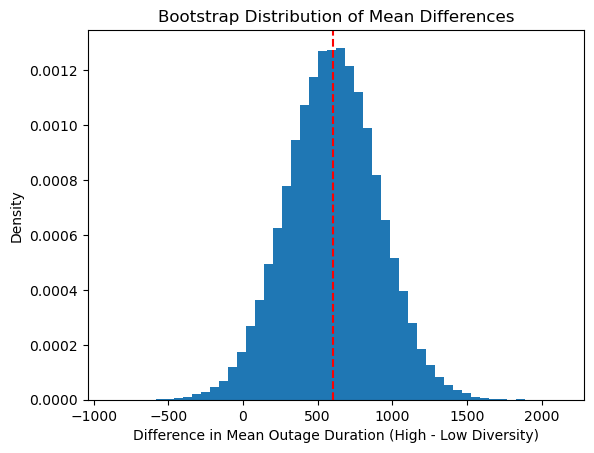

In [42]:
plt.hist(diffs, bins=50, density=True)
plt.axvline(obs_diff, color='red', linestyle='--')
plt.title('Bootstrap Distribution of Mean Differences')
plt.xlabel('Difference in Mean Outage Duration (High - Low Diversity)')
plt.ylabel('Density')


In [43]:
df = merged_outage.copy()
threshold = df['generation_fuel_diversity_index'].median()
high_div = df[df['generation_fuel_diversity_index'] >= threshold]['duration'].dropna().values
low_div = df[df['generation_fuel_diversity_index'] < threshold]['duration'].dropna().values

# Step 2: Observed difference in means
obs_diff = np.mean(high_div) - np.mean(low_div)

# Step 3: Bootstrap
n_iterations = 100000
diffs = []

for _ in range(n_iterations):
    sample_high = np.random.choice(high_div, size=len(high_div), replace=True)
    sample_low = np.random.choice(low_div, size=len(low_div), replace=True)
    diff = np.mean(sample_high) - np.mean(sample_low)
    diffs.append(diff)

# Step 4: P-value (two-tailed)
diffs = np.array(diffs)
p_val = np.mean(np.abs(diffs) >= np.abs(obs_diff))

print(f'Observed Difference: {obs_diff:.3f}')
print(f'Bootstrap p-value: {p_val:.3f}')


Observed Difference: 419.587
Bootstrap p-value: 0.491


In [44]:

# Step 1: Split data
outage_counts = outage.groupby(['state', 'year']).size().reset_index(name='outage_count')
merged = outage_counts.merge(capacity_entropy, on=['state', 'year'], how='left')

threshold = merged['capacity_fuel_diversity_index'].median()
high_div = merged[merged['capacity_fuel_diversity_index'] >= threshold]['outage_count'].values
low_div = merged[merged['capacity_fuel_diversity_index'] < threshold]['outage_count'].values
obs_diff = np.mean(high_div) - np.mean(low_div)

n_iterations = 10000
diffs = []
for _ in range(n_iterations):
    sample_high = np.random.choice(high_div, size=len(high_div), replace=True)
    sample_low = np.random.choice(low_div, size=len(low_div), replace=True)
    diffs.append(np.mean(sample_high) - np.mean(sample_low))

p_val = np.mean(np.array(diffs) <= obs_diff)  # one-tailed if expecting fewer outages

p_val

/var/folders/q9/dv0qd5v93jv_7gz3d0y5d0xc0000gn/T/ipykernel_64234/251110048.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



np.float64(0.5021)

In [45]:

# Step 1: Split data
outage_counts = outage.groupby(['state', 'year']).size().reset_index(name='outage_count')
merged = outage_counts.merge(capacity_entropy, on=['state', 'year'], how='left')

threshold = merged['capacity_fuel_diversity_index'].median()
high_div = merged[merged['capacity_fuel_diversity_index'] >= threshold]['outage_count'].values
low_div = merged[merged['capacity_fuel_diversity_index'] < threshold]['outage_count'].values
obs_diff = np.mean(high_div) - np.mean(low_div)

n_iterations = 10000
diffs = []
for _ in range(n_iterations):
    sample_high = np.random.choice(high_div, size=len(high_div), replace=True)
    sample_low = np.random.choice(low_div, size=len(low_div), replace=True)
    diffs.append(np.mean(sample_high) - np.mean(sample_low))

p_val = np.mean(np.array(diffs) <= obs_diff)  # one-tailed if expecting fewer outages

p_val

/var/folders/q9/dv0qd5v93jv_7gz3d0y5d0xc0000gn/T/ipykernel_64234/251110048.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



np.float64(0.5048)

In [46]:
generation = pd.read_csv('annual_generation_state.csv', skiprows=1)
generation

,YEAR,STATE,TYPE OF PRODUCER,ENERGY SOURCE,GENERATION (Megawatthours)
0,1990,AK,Total Electric Power Industry,Total,"5,599,506"
1,1990,AK,Total Electric Power Industry,Coal,"510,573"
2,1990,AK,Total Electric Power Industry,Hydroelectric Conventional,"974,521"
3,1990,AK,Total Electric Power Industry,Natural Gas,"3,466,261"
4,1990,AK,Total Electric Power Industry,Petroleum,"497,116"
...,...,...,...,...,...
62277,2023,WY,"Electric Generators, Electric Utilities",Coal,"29,830,879"
62278,2023,WY,"Electric Generators, Electric Utilities",Hydroelectric Conventional,"908,133"
62279,2023,WY,"Electric Generators, Electric Utilities",Natural Gas,"1,430,842"
62280,2023,WY,"Electric Generators, Electric Utilities",Petroleum,"43,712"


In [47]:
generation['ENERGY SOURCE'].unique()

array(['Total', 'Coal', 'Hydroelectric Conventional', 'Natural Gas',
       'Petroleum', 'Wind', 'Wood and Wood Derived Fuels', 'Nuclear',
       'Other Biomass', 'Other Gases', 'Pumped Storage', 'Geothermal',
       'Other', 'Solar Thermal and Photovoltaic'], dtype=object)

In [48]:
capacity = pd.read_csv('existcapacity_annual.csv', skiprows=1)
capacity

,Year,State Code,Producer Type,Fuel Source,Generators,Facilities,Nameplate Capacity (Megawatts),Summer Capacity (Megawatts)
0,1990,AK,"Combined Heat and Power, Commercial Power",All Sources,NaN,4,85.9,80.1
1,1990,AK,"Combined Heat and Power, Commercial Power",Coal,NaN,3,65.5,61.1
2,1990,AK,"Combined Heat and Power, Commercial Power",Petroleum,NaN,1,20.4,19.0
3,1990,AK,"Combined Heat and Power, Industrial Power",All Sources,NaN,23,229.4,204.2
4,1990,AK,"Combined Heat and Power, Industrial Power",Natural Gas,NaN,28,159.3,136.7
...,...,...,...,...,...,...,...,...
53997,2023,WY,Total Electric Power Industry,Other,3,2,13.3,13.3
53998,2023,WY,Total Electric Power Industry,Other Gases,4,2,3.7,3.3
53999,2023,WY,Total Electric Power Industry,Petroleum,4,3,5.8,5.8
54000,2023,WY,Total Electric Power Industry,Solar Thermal and Photovoltaic,1,1,92.0,92.0


In [49]:
capacity['Fuel Source'].unique()

array(['All Sources', 'Coal', 'Petroleum', 'Natural Gas',
       'Wood and Wood Derived Fuels', 'Hydroelectric', 'Wind',
       'Other Gases', 'Nuclear', 'Other Biomass', 'Pumped Storage',
       'Geothermal', 'Solar Thermal and Photovoltaic', 'Other', nan],
      dtype=object)

In [50]:
merged_outage

,year,state,climate_region,anomaly_level,climate_cat,cause_cat,cause_detail,duration,pc_realgsp_state,pi_util_of_usa,...,pop_pct_uc,popden_urban,popden_uc,popden_rural,area_pct_urban,area_pct_uc,yearly_outage_count_bystate,yearly_avg_duration_bystate,capacity_fuel_diversity_index,generation_fuel_diversity_index
0,2011,MN,East North Central,-0.3,normal,severe weather,NaN,3060.0,51268,2.2,...,15.28,2279,1700.5,18.2,2.14,0.6,3,1460.666667,1.045207,0.978170
1,2014,MN,East North Central,-0.1,normal,intentional attack,vandalism,1.0,53499,2.2,...,15.28,2279,1700.5,18.2,2.14,0.6,2,30.500000,1.065896,0.999916
2,2010,MN,East North Central,-1.5,cold,severe weather,heavy wind,3000.0,50447,2.1,...,15.28,2279,1700.5,18.2,2.14,0.6,3,2610.000000,1.032858,0.969911
3,2012,MN,East North Central,-0.1,normal,severe weather,thunderstorm,2550.0,51598,2.2,...,15.28,2279,1700.5,18.2,2.14,0.6,1,2550.000000,1.049795,1.013572
4,2015,MN,East North Central,1.2,warm,severe weather,NaN,1740.0,54431,2.2,...,15.28,2279,1700.5,18.2,2.14,0.6,2,947.500000,1.072869,1.004192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1529,2011,ND,West North Central,-0.9,cold,public appeal,NaN,720.0,57012,0.5,...,19.9,2192.2,1868.2,3.9,0.27,0.1,1,720.000000,0.955364,0.888903
1530,2006,ND,West North Central,NaN,NaN,fuel supply emergency,coal,NaN,42913,0.7,...,19.9,2192.2,1868.2,3.9,0.27,0.1,1,NaN,0.787179,0.743775
1531,2009,SD,West North Central,0.5,warm,islanding,NaN,59.0,45230,0.3,...,26.73,2038.3,1905.4,4.7,0.3,0.15,2,120.000000,0.848782,0.793590
1532,2009,SD,West North Central,0.5,warm,islanding,NaN,181.0,45230,0.3,...,26.73,2038.3,1905.4,4.7,0.3,0.15,2,120.000000,0.848782,0.793590
